In [1]:
import numpy as np
import pyomo.environ as pyo
from pyomo.environ import ConcreteModel, Var, ConstraintList, Objective, SolverFactory, value, RangeSet

import jax
import jax.numpy as jnp

# -------------- helper libraries -------------- #
import sys
import os
import time
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import importlib

collocation2_path = os.path.abspath(os.path.join('..', '00_utils'))

# Add the directory to sys.path
if collocation2_path not in sys.path:
    sys.path.append(collocation2_path)

from collocation import compute_weights, lagrange_derivative
from interpolation import BarycentricInterpolation
from data_generation import generate_ode_data
from non_parametric_collocation import collocate_data

## Data Generation - Equally Spaced

In [26]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 200
noise_level = 0.2
ode_type, params = "harmonic_oscillator", {"omega_squared": 2}
start_time, end_time = 0, 10
spacing_type = "equally_spaced" # "equally_spaced" or "chebyshev"
initial_state = np.array([0.0, 1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t_ho, y_ho, y_noisy_ho, true_derivatives_ho = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy_ho = np.array(jnp.squeeze(y_noisy_ho))
t_ho = np.array(jnp.squeeze(t_ho))

#-----------------------------------------COLLOCATION MATRIX PREPARATION-------------------------------------------#
#weights_ho = compute_weights(t_ho)
#D_ho = np.array(lagrange_derivative(t_ho, weights_ho))

#---------------------------------------------------TEST DATA--------------------------------------------#
t_test_ho, y_test_ho, _, _ = generate_ode_data(N*2, noise_level, ode_type, params, start_time, end_time*2, "uniform", initial_state)

#--------------------------------------------NON-PARAMETRIC COLLOCATION--------------------------------------------#
estimated_derivative_ho, estimated_solution_ho = collocate_data(y_noisy_ho, t_ho, 'EpanechnikovKernel', bandwidth=0.5)

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_utils/non_parametric_collocation.py:95: UserWarning: Data transposed to match expected dimensions.
  warnings.warn("Data transposed to match expected dimensions.")


### Pyomo, continuous, equally spaces

In [38]:
import nn_pyomo_continious
importlib.reload(nn_pyomo_continious)
NeuralODEPyomo_cont = nn_pyomo_continious.NeuralODEPyomo

layer_widths = [2, 20, 2]

# solver.options['print_level'] = 5
tol = 1e-2
params = {"tol":1e-2, 
          "dual_inf_tol": tol, 
          "compl_inf_tol": tol,
          "constr_viol_tol": tol, 
          
          # repeat the same for the acceptable tolerances
          "acceptable_tol": 1e-15,
          "acceptable_constr_viol_tol": 1e-15,
          "acceptable_dual_inf_tol": 1e-15,
          "acceptable_compl_inf_tol": 1e-15,
          "acceptable_iter": 0, 
          
          "halt_on_ampl_error" : 'yes',
          "print_level": 5, 
          #"hessian_approximation": 'limited-memory', 
          #"mu_strategy": 'adaptive', 
          #"check_derivatives_for_naninf": 'yes',
          "max_iter": 1000}

y0 = np.array([0.0, 1.0])
solver_time = 0
mae_train, mae_test = 0, 0
for i in range(10):
    start_timer_build = time.time()
    ode_model = NeuralODEPyomo_cont(np.array(y_noisy_ho), # y
                            np.array(t_ho), # t
                            np.array(None),
                            
                            layer_widths, act_func = "tanh", 
                            y_init = np.array(estimated_solution_ho), 
                            penalty_lambda_reg = 0.1, 
                            time_invariant = True,
                            # extra_input 
                            w_init_method = 'xavier', 
                            params = params,
                            deriv_method = "pyomo",
                            is_continuous = True
                            )

    ode_model.build_model()
    end_timer_build = time.time()
    result = ode_model.solve_model()
    u_model = ode_model.extract_solution()
    solver_time += result['solver_time']
    
    y_pred = ode_model.neural_ode(y0, t_ho)
    y1 = y_test_ho[-1]
    y_pred_test = ode_model.neural_ode(y0, t_test_ho)
    
    mae_train += np.mean(np.abs(y_ho - y_pred))
    mae_test += np.mean(np.abs(y_test_ho - y_pred_test))


Ipopt 3.14.16: tol=0.01
dual_inf_tol=0.01
compl_inf_tol=0.01
constr_viol_tol=0.01
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=1000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   106266
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   121475

Total number of variables............................:     2492
                 

In [42]:
print(f"Average time elpased: {solver_time/10:.3f}")
print(f"Average mae_train: {mae_train/10:.3f}")
print(f"Average mae_test: {mae_test/10:.3f}")

Average time elpased: 5.128
Average mae_train: 0.020
Average mae_test: 0.021


Mean Absolute Error - Direct: 0.15196313652740862
Mean Absolute Error - ODE solver: 0.1541199742131654


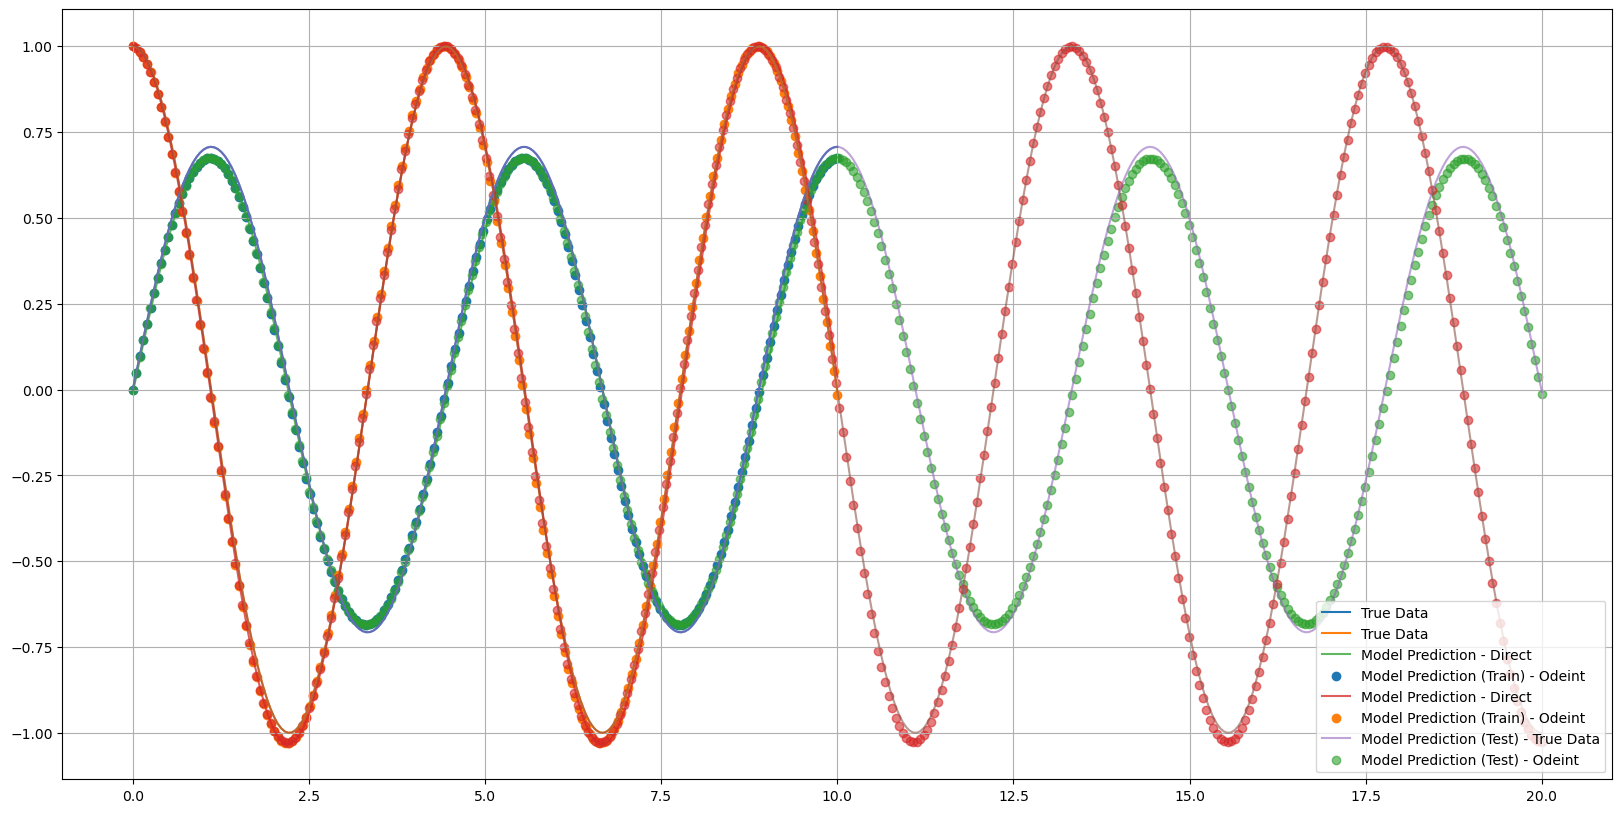

In [43]:
y0 = np.array([0.0, 1.0])
y_pred = ode_model.neural_ode(y0, t_ho)
y1 = y_test_ho[-1]
y_pred_test = ode_model.neural_ode(y0, t_test_ho)

print(f"Mean Absolute Error - Direct: {np.mean(np.abs(y_noisy_ho.T - u_model))}")
print(f"Mean Absolute Error - ODE solver: {np.mean(np.abs(y_noisy_ho - y_pred))}")

#y0_test = y_test_scaled[0]
#y_pred_test = ode_model.neural_ode(y0_test, ts_test, (Xs_test, ts_test))

plt.figure(figsize=(20, 10))
plt.plot(t_ho, y_ho, label='True Data', alpha = 1)

plt.plot(t_ho, u_model[0], label='Model Prediction - Direct', alpha = 0.75)
plt.scatter(t_ho, y_pred[:,0], label='Model Prediction (Train) - Odeint')
plt.plot(t_ho, u_model[1], label='Model Prediction - Direct', alpha = 0.75)
plt.scatter(t_ho, y_pred[:,1], label='Model Prediction (Train) - Odeint')

plt.plot(t_test_ho, y_test_ho[:,0], label='Model Prediction (Test) - True Data', alpha = 0.6)
plt.plot(t_test_ho, y_test_ho[:,1], alpha = 0.6)
plt.scatter(t_test_ho, y_pred_test[:,0], label='Model Prediction (Test) - Odeint', alpha = 0.6)
plt.scatter(t_test_ho, y_pred_test[:,1], alpha = 0.6)
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

## Data Generation - Chebyshev Spacing

In [44]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 200
noise_level = 0.2
ode_type, params = "harmonic_oscillator", {"omega_squared": 2}
start_time, end_time = 0, 10
spacing_type = "chebyshev" # "equally_spaced" or "chebyshev"
initial_state = jnp.array([0.0, 1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t_ho_cheb, y_ho_cheb, y_noisy_ho_cheb, true_derivatives_ho_cheb = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy_ho_cheb = np.array(jnp.squeeze(y_noisy_ho_cheb))
t_ho_cheb = np.array(jnp.squeeze(t_ho_cheb))

#-----------------------------------------COLLOCATION MATRIX PREPARATION-------------------------------------------#
weights_ho_cheb = compute_weights(t_ho_cheb)
D_ho_cheb = np.array(lagrange_derivative(t_ho_cheb, weights_ho_cheb))

#---------------------------------------------------TEST DATA--------------------------------------------#
t_test_ho_cheb, y_test_ho_cheb, _, _ = generate_ode_data(N*2, noise_level, ode_type, params, start_time, 20, "uniform", initial_state)

#--------------------------------------------NON-PARAMETRIC COLLOCATION--------------------------------------------#
estimated_derivative_ho_cheb, estimated_solution_ho_cheb = collocate_data(y_noisy_ho_cheb, t_ho_cheb, 'EpanechnikovKernel', bandwidth=0.5)

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_utils/non_parametric_collocation.py:95: UserWarning: Data transposed to match expected dimensions.
  warnings.warn("Data transposed to match expected dimensions.")


### Pyomo base - discrete

In [9]:
import nn_pyomo_base
importlib.reload(nn_pyomo_base)
NeuralODEPyomo_base = nn_pyomo_base.NeuralODEPyomo

In [45]:
layer_widths = [2, 20, 2]

# solver.options['print_level'] = 5
tol = 1e-2
params = {"tol":1e-2, 
          "dual_inf_tol": tol, 
          "compl_inf_tol": tol,
          "constr_viol_tol": tol, 
          
          # repeat the same for the acceptable tolerances
          "acceptable_tol": 1e-15,
          "acceptable_constr_viol_tol": 1e-15,
          "acceptable_dual_inf_tol": 1e-15,
          "acceptable_compl_inf_tol": 1e-15,
          "acceptable_iter": 0, 
          
          "halt_on_ampl_error" : 'yes',
          "print_level": 5, 
          #"hessian_approximation": 'limited-memory', 
          #"mu_strategy": 'adaptive', 
          #"check_derivatives_for_naninf": 'yes',
          "max_iter": 200}

y0 = np.array([0.0, 1.0])
solver_time = 0
mae_train, mae_test = 0, 0
for i in range(10):
    start_timer_build = time.time()
    ode_model = NeuralODEPyomo_base(np.array(y_noisy_ho_cheb), # y
                            np.array(t_ho_cheb), # t
                            np.array(D_ho_cheb),
                            
                            layer_widths, act_func = "tanh", 
                            y_init = np.array(estimated_solution_ho_cheb), 
                            penalty_lambda_reg = 0.1, 
                            time_invariant = True,
                            # extra_input 
                            w_init_method = 'xavier', 
                            params = params,
                            constraint="l1"
                            )

    ode_model.build_model()
    end_timer_build = time.time()
    result = ode_model.solve_model()
    u_model = ode_model.extract_solution()
    solver_time += result['solver_time']
    
    y_pred = ode_model.neural_ode(y0, t_ho)
    y1 = y_test_ho[-1]
    y_pred_test = ode_model.neural_ode(y0, t_test_ho)
    
    mae_train += np.mean(np.abs(y_ho - y_pred))
    mae_test += np.mean(np.abs(y_test_ho - y_pred_test))

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/01_neural_nets_2d_comparisons/nn_pyomo_base.py:116: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=0.01
dual_inf_tol=0.01
compl_inf_tol=0.01
constr_viol_tol=0.01
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=200


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   112236
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   120282

Total number of variables............................:      502
                  

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/01_neural_nets_2d_comparisons/nn_pyomo_base.py:116: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=0.01
dual_inf_tol=0.01
compl_inf_tol=0.01
constr_viol_tol=0.01
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=200


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   112236
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   120282

Total number of variables............................:      502
                  

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/01_neural_nets_2d_comparisons/nn_pyomo_base.py:116: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=0.01
dual_inf_tol=0.01
compl_inf_tol=0.01
constr_viol_tol=0.01
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=200


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   112236
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   120282

Total number of variables............................:      502
                  

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/01_neural_nets_2d_comparisons/nn_pyomo_base.py:116: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=0.01
dual_inf_tol=0.01
compl_inf_tol=0.01
constr_viol_tol=0.01
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=200


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   112236
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   120282

Total number of variables............................:      502
                  

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/01_neural_nets_2d_comparisons/nn_pyomo_base.py:116: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=0.01
dual_inf_tol=0.01
compl_inf_tol=0.01
constr_viol_tol=0.01
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=200


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   112236
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   120282

Total number of variables............................:      502
                  

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/01_neural_nets_2d_comparisons/nn_pyomo_base.py:116: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=0.01
dual_inf_tol=0.01
compl_inf_tol=0.01
constr_viol_tol=0.01
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=200


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   112236
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   120282

Total number of variables............................:      502
                  

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/01_neural_nets_2d_comparisons/nn_pyomo_base.py:116: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=0.01
dual_inf_tol=0.01
compl_inf_tol=0.01
constr_viol_tol=0.01
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=200


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   112236
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   120282

Total number of variables............................:      502
                  

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/01_neural_nets_2d_comparisons/nn_pyomo_base.py:116: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=0.01
dual_inf_tol=0.01
compl_inf_tol=0.01
constr_viol_tol=0.01
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=200


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   112236
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   120282

Total number of variables............................:      502
                  

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/01_neural_nets_2d_comparisons/nn_pyomo_base.py:116: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=0.01
dual_inf_tol=0.01
compl_inf_tol=0.01
constr_viol_tol=0.01
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=200


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   112236
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   120282

Total number of variables............................:      502
                  

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/01_neural_nets_2d_comparisons/nn_pyomo_base.py:116: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=0.01
dual_inf_tol=0.01
compl_inf_tol=0.01
constr_viol_tol=0.01
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=200


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   112236
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   120282

Total number of variables............................:      502
                  

In [1]:
print(f"Average time elpased: {solver_time/10:.3f}")
print(f"Average mae_train: {mae_train/10:.3f}")
print(f"Average mae_test: {mae_test/10:.3f}")

NameError: name 'solver_time' is not defined

Mean Absolute Error - Direct: 0.15232624130805392
Mean Absolute Error - ODE solver: 0.15288157708158207


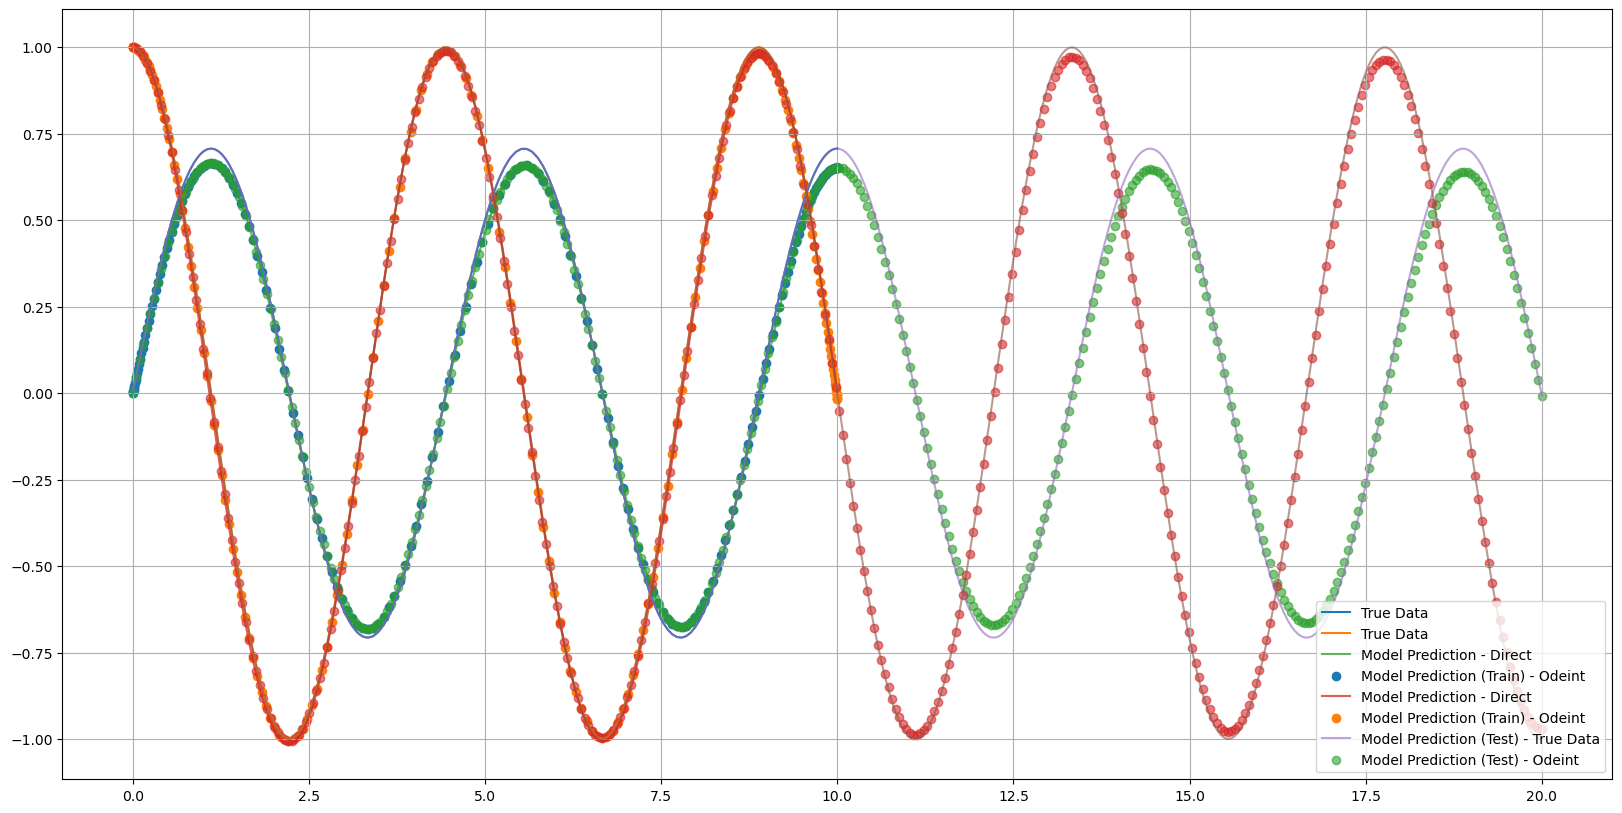

In [13]:
y0 = np.array([0.0, 1.0])
y_pred = ode_model.neural_ode(y0, t_ho_cheb)
y1 = y_test_ho_cheb[-1]
y_pred_test = ode_model.neural_ode(y0, t_test_ho_cheb)

print(f"Mean Absolute Error - Direct: {np.mean(np.abs(y_noisy_ho_cheb.T - u_model))}")
print(f"Mean Absolute Error - ODE solver: {np.mean(np.abs(y_noisy_ho_cheb - y_pred))}")

#y0_test = y_test_scaled[0]
#y_pred_test = ode_model.neural_ode(y0_test, ts_test, (Xs_test, ts_test))

plt.figure(figsize=(20, 10))
plt.plot(t_ho_cheb, y_ho_cheb, label='True Data', alpha = 1)

plt.plot(t_ho_cheb, u_model[0], label='Model Prediction - Direct', alpha = 0.75)
plt.scatter(t_ho_cheb, y_pred[:,0], label='Model Prediction (Train) - Odeint')
plt.plot(t_ho_cheb, u_model[1], label='Model Prediction - Direct', alpha = 0.75)
plt.scatter(t_ho_cheb, y_pred[:,1], label='Model Prediction (Train) - Odeint')

plt.plot(t_test_ho_cheb, y_test_ho_cheb[:,0], label='Model Prediction (Test) - True Data', alpha = 0.6)
plt.plot(t_test_ho_cheb, y_test_ho_cheb[:,1], alpha = 0.6)
plt.scatter(t_test_ho_cheb, y_pred_test[:,0], label='Model Prediction (Test) - Odeint', alpha = 0.6)
plt.scatter(t_test_ho_cheb, y_pred_test[:,1], alpha = 0.6)
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

---
---

In [48]:
import nn_pyomo_continious
importlib.reload(nn_pyomo_continious)
NeuralODEPyomo_cont = nn_pyomo_continious.NeuralODEPyomo

layer_widths = [2, 20, 2]

# solver.options['print_level'] = 5
tol = 1e-2
params = {"tol":1e-2, 
          "dual_inf_tol": tol, 
          "compl_inf_tol": tol,
          "constr_viol_tol": tol, 
          
          # repeat the same for the acceptable tolerances
          "acceptable_tol": 1e-15,
          "acceptable_constr_viol_tol": 1e-15,
          "acceptable_dual_inf_tol": 1e-15,
          "acceptable_compl_inf_tol": 1e-15,
          "acceptable_iter": 0, 
          
          "halt_on_ampl_error" : 'yes',
          "print_level": 5, 
          #"hessian_approximation": 'limited-memory', 
          #"mu_strategy": 'adaptive', 
          #"check_derivatives_for_naninf": 'yes',
          "max_iter": 1000}

y0 = np.array([0.0, 1.0])
solver_time = 0
mae_train, mae_test = 0, 0
for i in range(10):
    start_timer_build = time.time()
    ode_model = NeuralODEPyomo_cont(np.array(y_noisy_ho_cheb), # y
                            np.array(t_ho_cheb), # t
                            np.array(None),
                            
                            layer_widths, act_func = "tanh", 
                            y_init = np.array(estimated_solution_ho_cheb), 
                            penalty_lambda_reg = 0.1, 
                            time_invariant = True,
                            # extra_input 
                            w_init_method = 'xavier', 
                            params = params,
                            deriv_method = "pyomo",
                            is_continuous = True
                            )

    ode_model.build_model()
    end_timer_build = time.time()
    result = ode_model.solve_model()
    u_model = ode_model.extract_solution()
    solver_time += result['solver_time']
    
    y_pred = ode_model.neural_ode(y0, t_ho)
    y1 = y_test_ho[-1]
    y_pred_test = ode_model.neural_ode(y0, t_test_ho)
    
    mae_train += np.mean(np.abs(y_ho - y_pred))
    mae_test += np.mean(np.abs(y_test_ho - y_pred_test))

Ipopt 3.14.16: tol=0.01
dual_inf_tol=0.01
compl_inf_tol=0.01
constr_viol_tol=0.01
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=1000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   106266
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   121475

Total number of variables............................:     2492
                 

In [49]:
print(f"Average time elpased: {solver_time/10:.3f}")
print(f"Average mae_train: {mae_train/10:.3f}")
print(f"Average mae_test: {mae_test/10:.3f}")

Average time elpased: 5.524
Average mae_train: 0.021
Average mae_test: 0.030


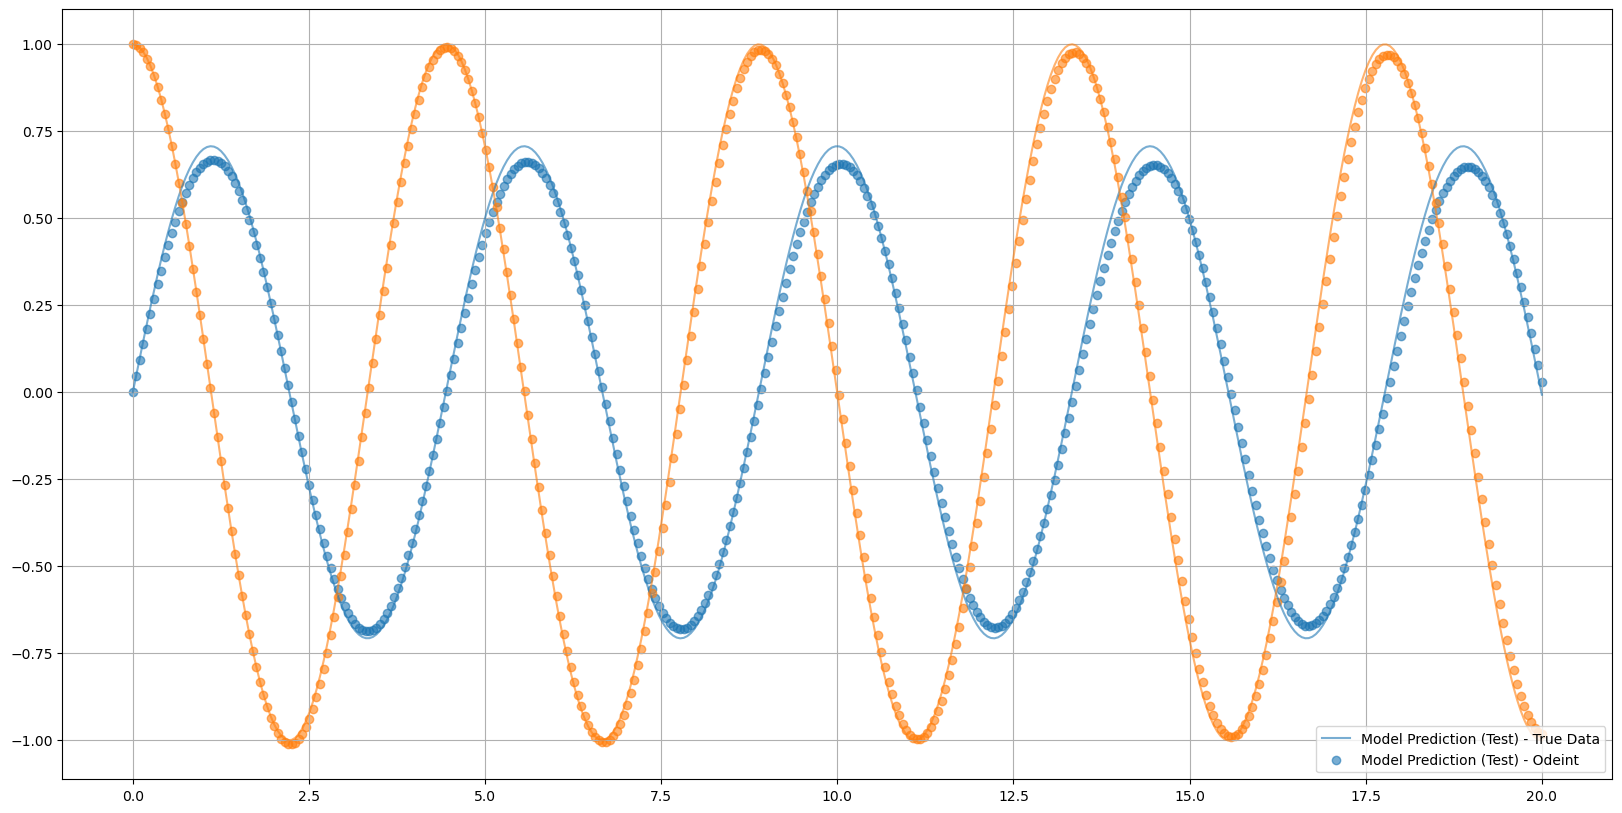

In [15]:
y0 = np.array([0.0, 1.0])
y_pred = ode_model.neural_ode(y0, t_ho_cheb)
y1 = y_test_ho_cheb[-1]
y_pred_test = ode_model.neural_ode(y0, t_test_ho_cheb)

#print(f"Mean Absolute Error - Direct: {np.mean(np.abs(y_ho_cheb - u_model))}")
#print(f"Mean Absolute Error - ODE solver: {np.mean(np.abs(y_ho_cheb - y_pred))}")

#y0_test = y_test_scaled[0]
#y_pred_test = ode_model.neural_ode(y0_test, ts_test, (Xs_test, ts_test))

plt.figure(figsize=(20, 10))
"""plt.plot(ts, y_ho_cheb, label='True Data', alpha = 1)

plt.plot(ts, u_model[0], label='Model Prediction - Direct', alpha = 0.75)
#plt.scatter(ts, y_pred[:,0], label='Model Prediction (Train) - Odeint')
plt.plot(ts, u_model[1], label='Model Prediction - Direct', alpha = 0.75)"""
#plt.scatter(ts, y_pred[:,1], label='Model Prediction (Train) - Odeint')

plt.plot(t_test_ho_cheb, y_test_ho_cheb[:,0], label='Model Prediction (Test) - True Data', alpha = 0.6)
plt.plot(t_test_ho_cheb, y_test_ho_cheb[:,1], alpha = 0.6)
plt.scatter(t_test_ho_cheb, y_pred_test[:,0], label='Model Prediction (Test) - Odeint', alpha = 0.6)
plt.scatter(t_test_ho_cheb, y_pred_test[:,1], alpha = 0.6)
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

In [20]:
np.array(t_ho_cheb).shape

(200,)

In [ ]:
y0 = np.array([0.0, 1.0])
solver_time = 0
mae_train, mae_test = 0, 0
for i in range(10):
    start_timer_build = time.time()
    ode_model = NeuralODEPyomo_cont(np.array(y_noisy_ho_cheb), # y
                            np.array(t_ho_cheb), # t
                            np.array(None),
                            
                            layer_widths, act_func = "tanh", 
                            y_init = np.array(estimated_solution_ho_cheb), 
                            penalty_lambda_reg = 0.1, 
                            time_invariant = True,
                            # extra_input 
                            w_init_method = 'xavier', 
                            params = params,
                            deriv_method = "pyomo",
                            is_continuous = True
                            )

    ode_model.build_model()
    end_timer_build = time.time()
    result = ode_model.solve_model()
    u_model = ode_model.extract_solution()
    solver_time += result['solver_time']
    
    y_pred = ode_model.neural_ode(y0, t_ho)
    y1 = y_test_ho[-1]
    y_pred_test = ode_model.neural_ode(y0, t_test_ho)
    
    mae_train += np.mean(np.abs(y_ho - y_pred))
    mae_test += np.mean(np.abs(y_test_ho - y_pred_test))

In [50]:
import nn_pyomo_continious
importlib.reload(nn_pyomo_continious)
NeuralODEPyomo_cont = nn_pyomo_continious.NeuralODEPyomo

layer_widths = [2, 20, 2]

# solver.options['print_level'] = 5
tol = 1e-2
params = {"tol":1e-2, 
          "dual_inf_tol": tol, 
          "compl_inf_tol": tol,
          "constr_viol_tol": tol, 
          
          # repeat the same for the acceptable tolerances
          "acceptable_tol": 1e-15,
          "acceptable_constr_viol_tol": 1e-15,
          "acceptable_dual_inf_tol": 1e-15,
          "acceptable_compl_inf_tol": 1e-15,
          "acceptable_iter": 0, 
          
          "halt_on_ampl_error" : 'yes',
          "print_level": 5, 
          #"hessian_approximation": 'limited-memory', 
          #"mu_strategy": 'adaptive', 
          #"check_derivatives_for_naninf": 'yes',
          "max_iter": 1000}

y0 = np.array([0.0, 1.0])
solver_time = 0
mae_train, mae_test = 0, 0
for i in range(10):
    ode_model = NeuralODEPyomo_cont(np.array(y_noisy_ho_cheb), # y
                            np.array(t_ho_cheb), # t
                            np.array(D_ho_cheb),
                            
                            layer_widths, act_func = "tanh", 
                            y_init = np.array(estimated_solution_ho_cheb), 
                            penalty_lambda_reg = 0.1, 
                            time_invariant = True,
                            w_init_method = 'xavier', 
                            params = params,
                            deriv_method = "collocation",
                            is_continuous = True
                            )

    ode_model.build_model()
    result = ode_model.solve_model()
    u_model = ode_model.extract_solution()
    solver_time += result['solver_time']
    
    y_pred = ode_model.neural_ode(y0, t_ho)
    y1 = y_test_ho[-1]
    y_pred_test = ode_model.neural_ode(y0, t_test_ho)
    
    mae_train += np.mean(np.abs(y_ho - y_pred))
    mae_test += np.mean(np.abs(y_test_ho - y_pred_test))

Ipopt 3.14.16: tol=0.01
dual_inf_tol=0.01
compl_inf_tol=0.01
constr_viol_tol=0.01
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=1000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   112236
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    40681

Total number of variables............................:      502
                 

In [51]:
print(f"Average time elpased: {solver_time/10:.3f}")
print(f"Average mae_train: {mae_train/10:.3f}")
print(f"Average mae_test: {mae_test/10:.3f}")

Average time elpased: 1.106
Average mae_train: 0.021
Average mae_test: 0.029


In [55]:
np.sum((y_ho - y_pred)**2)

Array(0.31532009, dtype=float64)

---
---